## 1. Import Libraries

In [88]:
from os.path import join
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
pd.options.mode.chained_assignment = None

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
import math

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, mean_squared_error, make_scorer, mean_absolute_error, mean_absolute_percentage_error

## 2. Merge all trip_metrics

In [89]:
#from google.colab import drive
#drive.mount('/content/drive')

In [90]:
trip_metrics_1 = pd.read_csv("../Yeni dosyalar/trip_metrics_1-6.csv")
trip_metrics_2 = pd.read_csv("../Yeni dosyalar/trip_metrics_7-12.csv")
trip_metrics_3 = pd.read_csv("../Yeni dosyalar/trip_metrics_13-18.csv")
trip_metrics_4 = pd.read_csv("../Yeni dosyalar/trip_metrics_19-24.csv")
trip_metrics_5 = pd.read_csv("../Yeni dosyalar/trip_metrics_25-30.csv")

df_list = [trip_metrics_1,trip_metrics_2,trip_metrics_3,trip_metrics_4,trip_metrics_5]
trips_merged = pd.concat(df_list)
trips_merged.to_csv('trips_merged.csv',index=False)



In [91]:
# if you have all data just use this method
trips_merged = pd.read_csv("../Yeni dosyalar/trips_merged.csv")
trips_merged

,ID,Energy_Consumption_kWh,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,...,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean,State_Name
0,vehicle_106_2013-01-02_trip_1,56.512577,2013-01-02 17:03:03,2013-01-03 06:59:37,30054,3.059713,25.543506,53.10822,0.0,0.682558,...,-36.0,186.0,0.0,27.401732,-0.701630,2538.156197,32.138279,0.094478,2.167538,New York
1,vehicle_106_2013-01-03_trip_1,67.325737,2013-01-03 07:00:39,2013-01-04 06:59:01,61184,5.406763,91.890939,54.71756,0.0,0.652998,...,-18.0,154.0,0.0,19.594187,0.645511,2509.308584,-4.814485,-0.027146,1.835317,New York
2,vehicle_106_2013-01-04_trip_1,73.932923,2013-01-04 07:00:03,2013-01-05 06:45:37,65658,0.615856,11.232193,54.71756,0.0,0.654898,...,-25.0,100.0,0.0,14.865846,2.540228,2507.926606,99.693687,0.191294,1.923882,New York
3,vehicle_106_2013-01-05_trip_1,-113.205677,2013-01-05 07:12:24,2013-01-06 01:34:20,52863,18.642805,273.754051,54.71756,0.0,0.620325,...,-134.0,405.0,0.0,56.241256,4.485057,2517.485382,-6.452550,-0.015366,2.153184,New York
4,vehicle_106_2013-01-07_trip_1,0.082100,2013-01-08 03:24:30,2013-01-08 06:59:59,12929,0.000875,0.003143,1.60934,0.0,0.447039,...,-4.0,55.0,0.0,20.422091,8.330394,2499.255762,65241.277748,91728.000000,2.113689,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10314,vehicle_441_2015-01-07_trip_1,48.259822,2015-01-07 09:16:14,2015-01-08 01:38:05,6153,30.360591,51.891309,54.71756,0.0,0.615739,...,-37.0,118.0,0.0,25.376619,-6.627231,NaN,-0.303934,-0.000381,1.809065,New Jersey
10315,vehicle_441_2015-01-08_trip_1,50.762781,2015-01-08 07:40:24,2015-01-09 01:09:45,6965,28.826084,55.770466,54.71756,0.0,0.601900,...,-43.0,94.0,0.0,25.596772,-10.669776,NaN,-0.565587,-0.000774,1.791352,New Jersey
10316,vehicle_441_2015-01-09_trip_1,44.076312,2015-01-09 07:02:21,2015-01-10 01:01:30,5877,27.029152,44.125091,54.71756,0.0,0.625577,...,-23.0,103.0,0.0,28.478131,-3.154897,NaN,-8.202602,-0.008253,1.778323,New Jersey
10317,vehicle_441_2015-01-10_trip_1,41.304916,2015-01-10 09:12:36,2015-01-11 00:05:32,6125,23.705111,40.331612,54.71756,0.0,0.615101,...,-57.0,123.0,0.0,29.333582,-8.270477,NaN,13.646722,0.014555,1.676657,New Jersey


## 3. Feature Enginnering

In [63]:
trips_merged['Start_Time'] = pd.to_datetime(trips_merged['Start_Time'])
trips_merged['End_Time'] = pd.to_datetime(trips_merged['End_Time'])

trips_merged['Start_Hour'] = trips_merged['Start_Time'].dt.hour
trips_merged['End_Hour'] = trips_merged['End_Time'].dt.hour

In [92]:
## handling the energy consumption values by dropping rows with value 0 and takinbg absolute value to remove negative consumptions
trips_merged['Energy_Consumption_kWh'] = trips_merged['Energy_Consumption_kWh'] / trips_merged['Total_Distance_km']
trips_merged = trips_merged.rename(columns={"Energy_Consumption_kWh": "Energy_Consumption_kWh/km"})
# trips_merged = trips_merged[trips_merged['Energy_Consumption_kWh/km'] !=0]
# trips_merged['Energy_Consumption_kWh/km'] = trips_merged['Energy_Consumption_kWh/km'].abs()

In [65]:
state_dict = ['Nebraska','内蒙古自治区','Алматы облысы','Pays de la Loire','Comunitat Valenciana','Michigan', None]
trips_merged['State_Name']  = trips_merged['State_Name'].replace(state_dict, 'Unknown')
trips_merged['State_Name'].unique()

array(['New York', 'Unknown', 'Indiana', 'Missouri', 'California',
       'Washington', 'Arizona', 'Maryland', 'District of Columbia',
       'New Jersey', 'Illinois', 'Wisconsin', 'Virginia'], dtype=object)

## 4. Splitting the data to train test

In [66]:
trips_merged = trips_merged.dropna()

In [67]:
cols_to_keep = ['Duration_s', 'Average_Speed_kmh', 'Max_Speed','Start_Hour','End_Hour',
       'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude',
       'Min_Altitude', 'GPS_Altitude_Mean', 'Average_Ambient_Temperature',
       'Average_air', 'Kinetic_Intensity', 'Traffic_Category_Mean',
       'State_Name','Total_Distance_km']

In [68]:
X = trips_merged[cols_to_keep]
y = trips_merged['Energy_Consumption_kWh/km']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55, stratify=X['State_Name'])

In [69]:
trips_merged

,ID,Energy_Consumption_kWh/km,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,...,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean,State_Name,Start_Hour,End_Hour
0,vehicle_106_2013-01-02_trip_1,2.212405,2013-01-02 17:03:03,2013-01-03 06:59:37,30054,3.059713,25.543506,53.10822,0.0,0.682558,...,0.0,27.401732,-0.701630,2538.156197,32.138279,0.094478,2.167538,New York,17,6
1,vehicle_106_2013-01-03_trip_1,0.732670,2013-01-03 07:00:39,2013-01-04 06:59:01,61184,5.406763,91.890939,54.71756,0.0,0.652998,...,0.0,19.594187,0.645511,2509.308584,-4.814485,-0.027146,1.835317,New York,7,6
2,vehicle_106_2013-01-04_trip_1,6.582234,2013-01-04 07:00:03,2013-01-05 06:45:37,65658,0.615856,11.232193,54.71756,0.0,0.654898,...,0.0,14.865846,2.540228,2507.926606,99.693687,0.191294,1.923882,New York,7,6
3,vehicle_106_2013-01-05_trip_1,0.413531,2013-01-05 07:12:24,2013-01-06 01:34:20,52863,18.642805,273.754051,54.71756,0.0,0.620325,...,0.0,56.241256,4.485057,2517.485382,-6.452550,-0.015366,2.153184,New York,7,1
4,vehicle_106_2013-01-07_trip_1,26.124524,2013-01-08 03:24:30,2013-01-08 06:59:59,12929,0.000875,0.003143,1.60934,0.0,0.447039,...,0.0,20.422091,8.330394,2499.255762,65241.277748,91728.000000,2.113689,New York,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10286,vehicle_441_2014-12-05_trip_1,1.046567,2014-12-05 07:01:28,2014-12-06 06:36:37,7763,20.488175,44.180473,54.71756,0.0,0.618775,...,0.0,24.552936,3.828719,6.000000,3.926777,0.003811,1.517015,New Jersey,7,6
10287,vehicle_441_2014-12-06_trip_1,0.996043,2014-12-06 07:17:32,2014-12-07 00:01:22,5249,26.268570,38.301034,54.71756,0.0,0.661012,...,0.0,28.939387,6.903609,6.000000,4.117782,0.004295,1.765444,New Jersey,7,0
10288,vehicle_441_2014-12-07_trip_1,1.266759,2014-12-07 23:11:49,2014-12-08 00:09:51,175,11.704291,0.568959,24.14010,0.0,0.679872,...,34.0,45.568182,4.068182,6.000000,332.640000,2.511233,1.000000,New Jersey,23,0
10296,vehicle_441_2014-12-15_trip_1,0.956629,2014-12-15 16:41:35,2014-12-16 06:12:01,6655,26.558385,49.096126,54.71756,0.0,0.635181,...,0.0,27.321165,5.305056,6.000000,3.212378,0.003466,1.725621,New Jersey,16,6


## Explatory Data Analysis

In [70]:
#merging energy consumption to another df to visualzie the train data better. This df_train will not be used in models
df_train = X_train.copy()
df_train['Energy_Consumption_kWh/km'] = y_train

<Axes: >

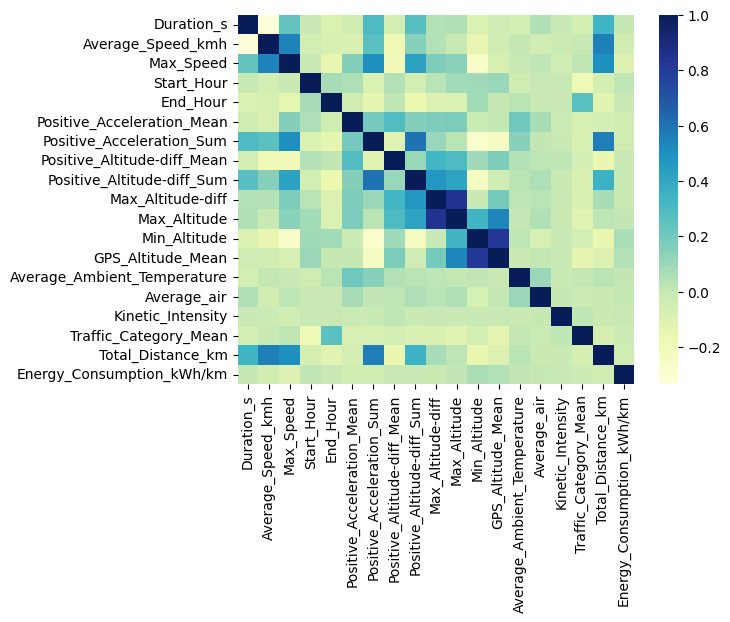

In [71]:
sns.heatmap(df_train.drop(columns=["State_Name"]).corr(), cmap="YlGnBu")

<Axes: >

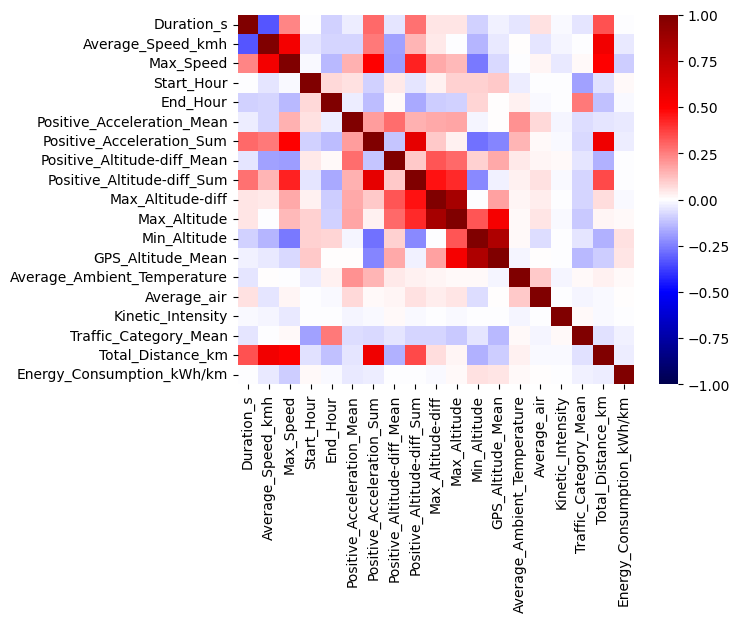

In [72]:
vmin = -1
vmax = 1
cmap = sns.color_palette(["red", "white", "green"])
sns.heatmap(df_train.drop(columns=["State_Name"]).corr(), cmap = "seismic" ,center=0,  fmt=".1f", vmin=vmin, vmax=vmax,)

In [73]:
df_train.drop(columns=['State_Name']).corr()


,Duration_s,Average_Speed_kmh,Max_Speed,Start_Hour,End_Hour,Positive_Acceleration_Mean,Positive_Acceleration_Sum,Positive_Altitude-diff_Mean,Positive_Altitude-diff_Sum,Max_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Kinetic_Intensity,Traffic_Category_Mean,Total_Distance_km,Energy_Consumption_kWh/km
Duration_s,1.000000,-0.335412,0.236396,-0.004852,-0.089325,-0.033616,0.296136,-0.049835,0.273974,0.048775,0.053641,-0.087091,-0.030878,-0.049144,0.054742,-0.009583,-0.052522,0.336010,-0.000446
Average_Speed_kmh,-0.335412,1.000000,0.545242,-0.052382,-0.079671,-0.081836,0.259605,-0.181970,0.144940,0.043003,-0.002885,-0.142724,-0.044223,0.004714,-0.048402,-0.018163,-0.005600,0.552004,-0.045625
Max_Speed,0.236396,0.545242,1.000000,-0.010713,-0.140469,0.152290,0.504289,-0.193800,0.430602,0.167148,0.139337,-0.264120,-0.070509,-0.003380,0.018389,-0.039885,0.014217,0.500842,-0.094528
Start_Hour,-0.004852,-0.052382,-0.010713,1.000000,0.075684,0.057226,-0.088239,0.042234,-0.053183,0.029808,0.086769,0.092103,0.103347,-0.035833,-0.002999,-0.005478,-0.186956,-0.059063,0.014778
End_Hour,-0.089325,-0.079671,-0.140469,0.075684,1.000000,-0.036214,-0.131510,0.014250,-0.166693,-0.094610,-0.088115,0.085931,0.000410,0.029155,-0.009263,-0.003034,0.260382,-0.121373,-0.009241
Positive_Acceleration_Mean,-0.033616,-0.081836,0.152290,0.057226,-0.036214,1.000000,0.193427,0.285542,0.152343,0.168883,0.173829,-0.021701,0.003328,0.211480,0.073437,-0.021040,-0.065869,-0.054001,-0.040946
Positive_Acceleration_Sum,0.296136,0.259605,0.504289,-0.088239,-0.131510,0.193427,1.000000,-0.115702,0.595417,0.106947,0.025149,-0.274821,-0.238420,0.147174,0.009624,-0.015029,-0.074438,0.559089,-0.037221
Positive_Altitude-diff_Mean,-0.049835,-0.181970,-0.193800,0.042234,0.014250,0.285542,-0.115702,1.000000,0.107012,0.328399,0.295862,0.088567,0.165560,0.045669,0.020230,0.014988,-0.054384,-0.155333,-0.004769
Positive_Altitude-diff_Sum,0.273974,0.144940,0.430602,-0.053183,-0.166693,0.152343,0.595417,0.107012,1.000000,0.468187,0.418455,-0.231183,-0.030378,0.029500,0.057311,-0.013725,-0.081025,0.352323,-0.006815
Max_Altitude-diff,0.048775,0.043003,0.167148,0.029808,-0.094610,0.168883,0.106947,0.328399,0.468187,1.000000,0.848509,-0.007229,0.186280,0.022049,0.034353,-0.001569,-0.080002,0.068202,-0.014265


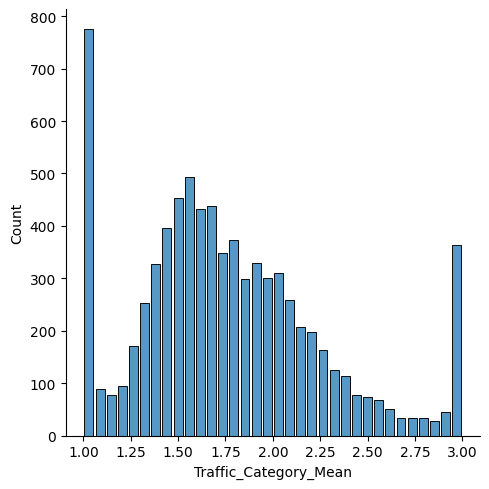

In [74]:
sns.displot(df_train, x="Traffic_Category_Mean", shrink=.8)

In [75]:
df_train.columns

Index(['Duration_s', 'Average_Speed_kmh', 'Max_Speed', 'Start_Hour',
       'End_Hour', 'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude', 'Min_Altitude',
       'GPS_Altitude_Mean', 'Average_Ambient_Temperature', 'Average_air',
       'Kinetic_Intensity', 'Traffic_Category_Mean', 'State_Name',
       'Total_Distance_km', 'Energy_Consumption_kWh/km'],
      dtype='object')

In [ ]:
# Create subplots for each plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))
# palette = sns.color_palette("husl", len(df_train["Traffic_Category_Mean"].unique()))

# # # Histogram
# sns.boxplot(data=df_train, x="Traffic_Category_Mean", y="Energy_Consumption_kWh/km", palette=palette, ax=axes[0,0])
# axes[0,0].set_title("Energy_Consumption_kWh by Traffic_Category_Mean (Box Plot)")

# Scatter plot
sns.scatterplot(data=df_train, x="Average_Speed_kmh", y="Energy_Consumption_kWh/km", ax=axes[0,1])
axes[0,1].set_title("Average_Speed_kmh vs Energy_Consumption_kWh")

# Bar plot
sns.barplot(data=df_train, x="Traffic_Category_Mean", y="Energy_Consumption_kWh/km",  ax=axes[0,2])
axes[0,2].set_title("Energy_Consumption_kWh by Traffic_Category_Mean")

# Scatter plot
sns.scatterplot(data=df_train, x="Kinetic_Intensity", y="Energy_Consumption_kWh/km", ax=axes[1,0])
axes[1,0].set_title("Kinetic_Intensity vs Energy_Consumption_kWh")

# # Additional plot 1
# sns.lineplot(data=df_train, x="Total Time(s)", y="Energy_Consumption_kWh", hue="Trip", palette=palette, ax=axes[1,0])
# axes[1,0].set_title("Battery Current over Time")

# # Additional plot 2
# sns.histplot(data=df_train, x="Battery_Current_SYS", hue="Trip", palette=palette, ax=axes[1,1])
# axes[1,1].set_title("Battery Current Distribution")

# Add overall title
plt.suptitle("Data Visualizations" , fontsize = 25, y= 1)

# Adjust layout and show
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


 ## 5. BaseLine Classifier

In [77]:
#This part was not in the feature engineering part as we have to startify our train test split according to city names so this part should come after that
X_train = pd.get_dummies(X_train, columns=['State_Name'], prefix="",prefix_sep="") 
X_test = pd.get_dummies(X_test, columns=['State_Name'], prefix="",prefix_sep="") 

In [82]:
def custom_metric(actual_values,predictions):
    if(actual_values == 0):
        return 0
    error = abs(predictions - actual_values) / actual_values
    if error <= 0.1:
        return 1
    else:
        return 0

In [ ]:
consumption_mean = y_train.mean()

df_temp = pd.DataFrame(y)
df_temp['baseline'] = consumption_mean
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['Energy_Consumption_kWh/km'],row['baseline']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Baseline Accuracy is:',accuracy)

Baseline Accuracy is: 0.0035758071107478543


## 6. Applying Machine Learning Models

### 6.1 Random Forest

In [79]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
clf = RandomForestRegressor(n_estimators=500)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(mse)


24050.90174614475


In [83]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['Energy_Consumption_kWh/km'],row['predictions']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

Accuracy is: 0.5061287027579162


### 6.2 XGBoost

In [155]:
mse = make_scorer(mean_squared_error)
params = {
    'max_depth': [9],
    'subsample':[0.9],
    'colsample_bytree':[0.9],
    'gamma':[0.3]
}

# create an XGB Boost instance
xgb_reg = XGBRegressor(

  
)

# searching the model
XGB_Model= GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=mse)


In [156]:
XGB_Model.fit(X_train, y_train)
predictions = XGB_Model.predict(X_test)

mse = mean_absolute_error(y_test, predictions)
print(mse)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
6.509385712585798


In [157]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['Energy_Consumption_kWh/km'],row['predictions']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

Accuracy is: 0.4790602655771195


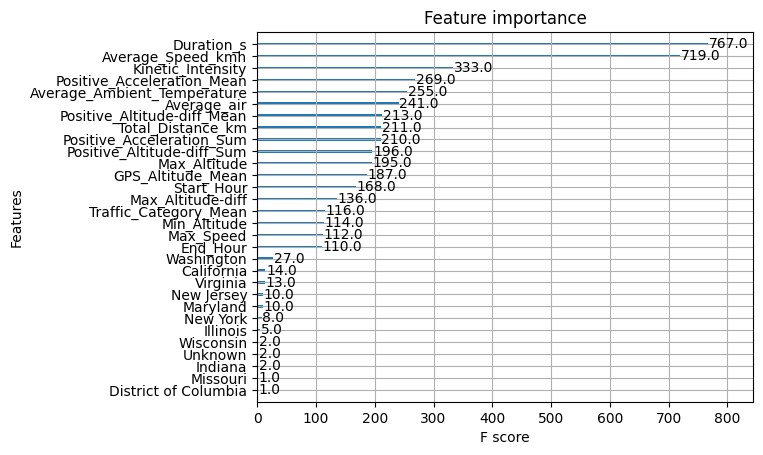

In [158]:
from xgboost import plot_importance
plot_importance(XGB_Model.best_estimator_)
plt.show()

### 6.3 Extra Trees

In [84]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
clf = ExtraTreesRegressor()
parameters = {
    'n_estimators': [50],
    'max_depth': [34],
    'min_samples_split': [ 21]
}
clf = GridSearchCV(clf, parameters, cv=5, verbose=True, scoring=mse)
clf.fit(X_train, y_train)
clf.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'max_depth': 34, 'min_samples_split': 21, 'n_estimators': 50}

In [86]:
predictions = clf.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(mse)


3843.820278439931


In [87]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['Energy_Consumption_kWh/km'],row['predictions']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

Accuracy is: 0.48723186925434114
